## Deep ensembles based training implementation

Implementing the methodology outlined in https://arxiv.org/pdf/1612.01474, except for the adversarial training. To modify to adversarial training, add gaussian noise to the training samples. Credit to the work goes completely to the authors and other parties mentioned in the paper, as per the paper.

### Defining model and loss function

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from functools import reduce


def _deep_ens_loss_(x, y):
    return torch.mean(torch.log(x[:, 1]**2)/2 + (y - x[:, 0])**2/(2*x[:, 1]**2))

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Apply ReLU activation to hidden layer
        x = torch.relu(self.hidden(x))
        # Apply output layer (no activation here, often softmax is applied externally if needed)
        x = self.output(x)
        return x


### Training

In [127]:
# Hyperparameters
input_size = 10     # Number of input features
hidden_size = 5     # Number of neurons in the hidden layer
output_size = 2     # Number of output neurons (for a binary classification task)
num_epochs = 20     # Number of training epochs
batch_size = 128     # Batch size for training
learning_rate = 0.0001  # Learning rate for the optimizer
num_ens = 10  # Number of ensembles

# Define a loss function and optimizer
criterion = _deep_ens_loss_
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use SGD optimizer

# Create a TensorDataset and DataLoader
num_samples = 10000
X = torch.randn(num_samples, input_size)  # Randomly generated input features
y = torch.randn(num_samples,)  # Randomly generated binary labels (0 or 1)
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

models = []
for i in range(num_ens):
    # Instantiate the model
    model = SimpleNN(input_size, hidden_size, output_size)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        avg_loss = running_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    models.append(model)

Epoch [1/20], Loss: 14850.8616
Epoch [2/20], Loss: 14832.2363
Epoch [3/20], Loss: 14832.9243
Epoch [4/20], Loss: 14832.1628
Epoch [5/20], Loss: 14835.2836
Epoch [6/20], Loss: 14834.4737
Epoch [7/20], Loss: 14834.2676
Epoch [8/20], Loss: 14837.1324
Epoch [9/20], Loss: 14887.1743
Epoch [10/20], Loss: 14833.3569
Epoch [11/20], Loss: 14832.8624
Epoch [12/20], Loss: 14833.0183
Epoch [13/20], Loss: 14833.2853
Epoch [14/20], Loss: 14899.0095
Epoch [15/20], Loss: 16218.0776
Epoch [16/20], Loss: 14835.7335
Epoch [17/20], Loss: 14833.5402
Epoch [18/20], Loss: 15104.6339
Epoch [19/20], Loss: 14833.6117
Epoch [20/20], Loss: 14833.3544
Epoch [1/20], Loss: 8492463.3216
Epoch [2/20], Loss: 8492108.1181
Epoch [3/20], Loss: 8492105.9874
Epoch [4/20], Loss: 8492051.4348
Epoch [5/20], Loss: 8492058.3910
Epoch [6/20], Loss: 8492074.2371
Epoch [7/20], Loss: 8492068.8603
Epoch [8/20], Loss: 8492051.3046
Epoch [9/20], Loss: 8494833.5934
Epoch [10/20], Loss: 8492055.7010
Epoch [11/20], Loss: 8492065.3097
Epoc

### Inference

In [129]:
# Create a TensorDataset and DataLoader
test_num_samples = 3000
X_test = torch.randn(test_num_samples, input_size)  # Randomly generated input features
y_test = torch.randn(test_num_samples,)   # Randomly generated binary labels (0 or 1)
test_dataset = TensorDataset(X_test, y_test)
test_data_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
for test_inputs, _ in test_data_loader:
    with torch.no_grad():  # Disable gradient calculation for evaluation
        test_outputs = [model(test_inputs) for model in models]
test_means = reduce(lambda x, y: torch.add(x, y), [output[:, 0] for output in test_outputs])/num_ens
test_var = reduce(lambda x, y: torch.add(x, y),
                  [torch.add(torch.pow(output[:, 0], 2), torch.pow(output[:, 1], 2))
                   for output in test_outputs])/num_ens - torch.pow(test_means, 2)

test_means has the mean and test_var has the variance for gaussian distribution of prediction

This plot below shows the distribution of the number of standard deviations each value in our test set is away from the mean (mean and standard deviations as calculated above). We expect the bulk to be in -2 to 2 (95% CI), and as expected, close to 2000 out of 3000 test samples are within 95% CI. A higher number of ensembles will improve this even further.

(array([  1.,   0.,   3.,   6.,   0.,   6.,   7.,  10.,   7.,  13.,  10.,
         23.,  17.,  33.,  37.,  52.,  45.,  61.,  92., 104., 121., 130.,
        132., 133., 139., 159., 174., 165., 157., 167., 139., 143., 117.,
         88., 103.,  81.,  68.,  61.,  42.,  34.,  30.,  22.,  15.,  17.,
         15.,   7.,   5.,   3.,   3.,   3.]),
 array([-7.80539036, -7.50426912, -7.20314837, -6.90202713, -6.60090637,
        -6.29978514, -5.99866438, -5.69754314, -5.39642239, -5.09530115,
        -4.79418039, -4.49305916, -4.1919384 , -3.89081717, -3.58969617,
        -3.28857517, -2.98745418, -2.68633318, -2.38521218, -2.08409095,
        -1.78297007, -1.48184907, -1.18072796, -0.87960702, -0.57848597,
        -0.27736497,  0.02375605,  0.32487705,  0.62599808,  0.92711908,
         1.22824013,  1.52936113,  1.83048213,  2.13160324,  2.43272424,
         2.73384523,  3.03496623,  3.33608723,  3.63720822,  3.93832922,
         4.23945045,  4.54057121,  4.84169245,  5.14281321,  5.44393444,
 

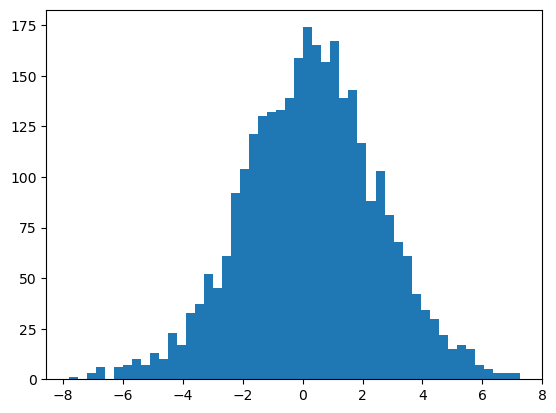

In [140]:
import matplotlib.pyplot as plt
plt.hist(torch.div(torch.sub(y_test, test_means), torch.sqrt(test_var)), bins=50)

In [148]:
import pandas as pd
pd.Series(torch.abs(torch.div(torch.sub(y_test, test_means), torch.sqrt(test_var))) > 2).value_counts()

False    1905
True     1095
Name: count, dtype: int64